In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import geopandas as gpd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Importamos librerias necesarias para validacion del modelo
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve


# librerias de Modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


In [29]:
geo_map = gpd.read_file("./shapefiles/taxi_zones.shp")
df = pd.read_parquet("./dataset_sample.parquet", engine = 'auto')
taxi_zones = pd.read_csv("./taxi+_zone_lookup.csv")

In [30]:
# De las columnas de amount, nos quedamos solo con fare_amount y tip_amount
# También dropeamos payment_type
drop_columns = ['tolls_amount','total_amount', 'payment_type']
df = df.drop(columns=drop_columns)

De las variables tpep_pickup_datetime tpep_dropoff_datetime  se puede obtener mas data, al distribuirla por hora, fecha, duracion de la trayectoria

In [75]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['date'] = df['tpep_pickup_datetime'].dt.normalize()
df['time_of_day'] = df['tpep_pickup_datetime'].dt.hour
df['month'] = df['tpep_pickup_datetime'].dt.month_name()
#df['weekday'] = df['date'].dt.day_name() <- irrelevante?
df['duration_m'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration_m'] = df['duration_m'] / np.timedelta64(1, 'm')
df['day_of_year'] =pd.to_datetime(df['tpep_dropoff_datetime']).dt.strftime('%m-%d')
cal = calendar()
holidays = cal.holidays(start='2022-01-01', end='2022-12-31')
df['holiday'] = df['date'].isin(holidays)
df['day_week'] = df['date'].dt.dayofweek
df.loc[df['day_week'] >= 5, 'day_type'] = "weekend"
df.loc[df['day_week'] < 5, 'day_type'] = "workday"
df.loc[df['holiday'] == True, 'day_type'] = "holiday"
df = df.drop(['holiday'], axis=1)

In [77]:
# RateCodeID es claramente categórica encubierta
df['RatecodeID'] = df['RatecodeID'].astype('category')
# AirportFee es booleana encubierta
df['airport_fee'] = df['airport_fee']>0

<Axes: >

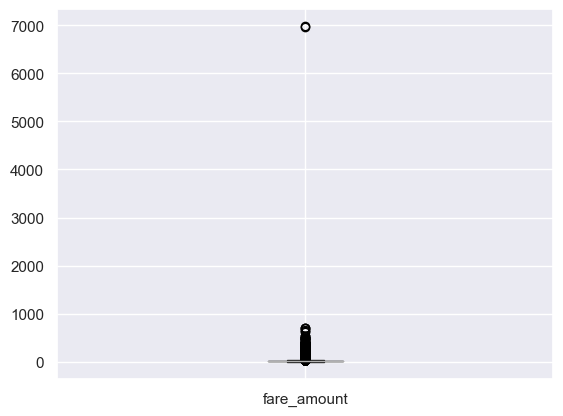

In [78]:
# observamos fare_amount
df[['fare_amount']].boxplot()

d:\Users\juanp_schamun\Documents\GitRepositories\CEIA\AD\CEIA_Analisis_de_datos\.venv\Lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Text(0.5, 1.0, 'Heatmap of payments')

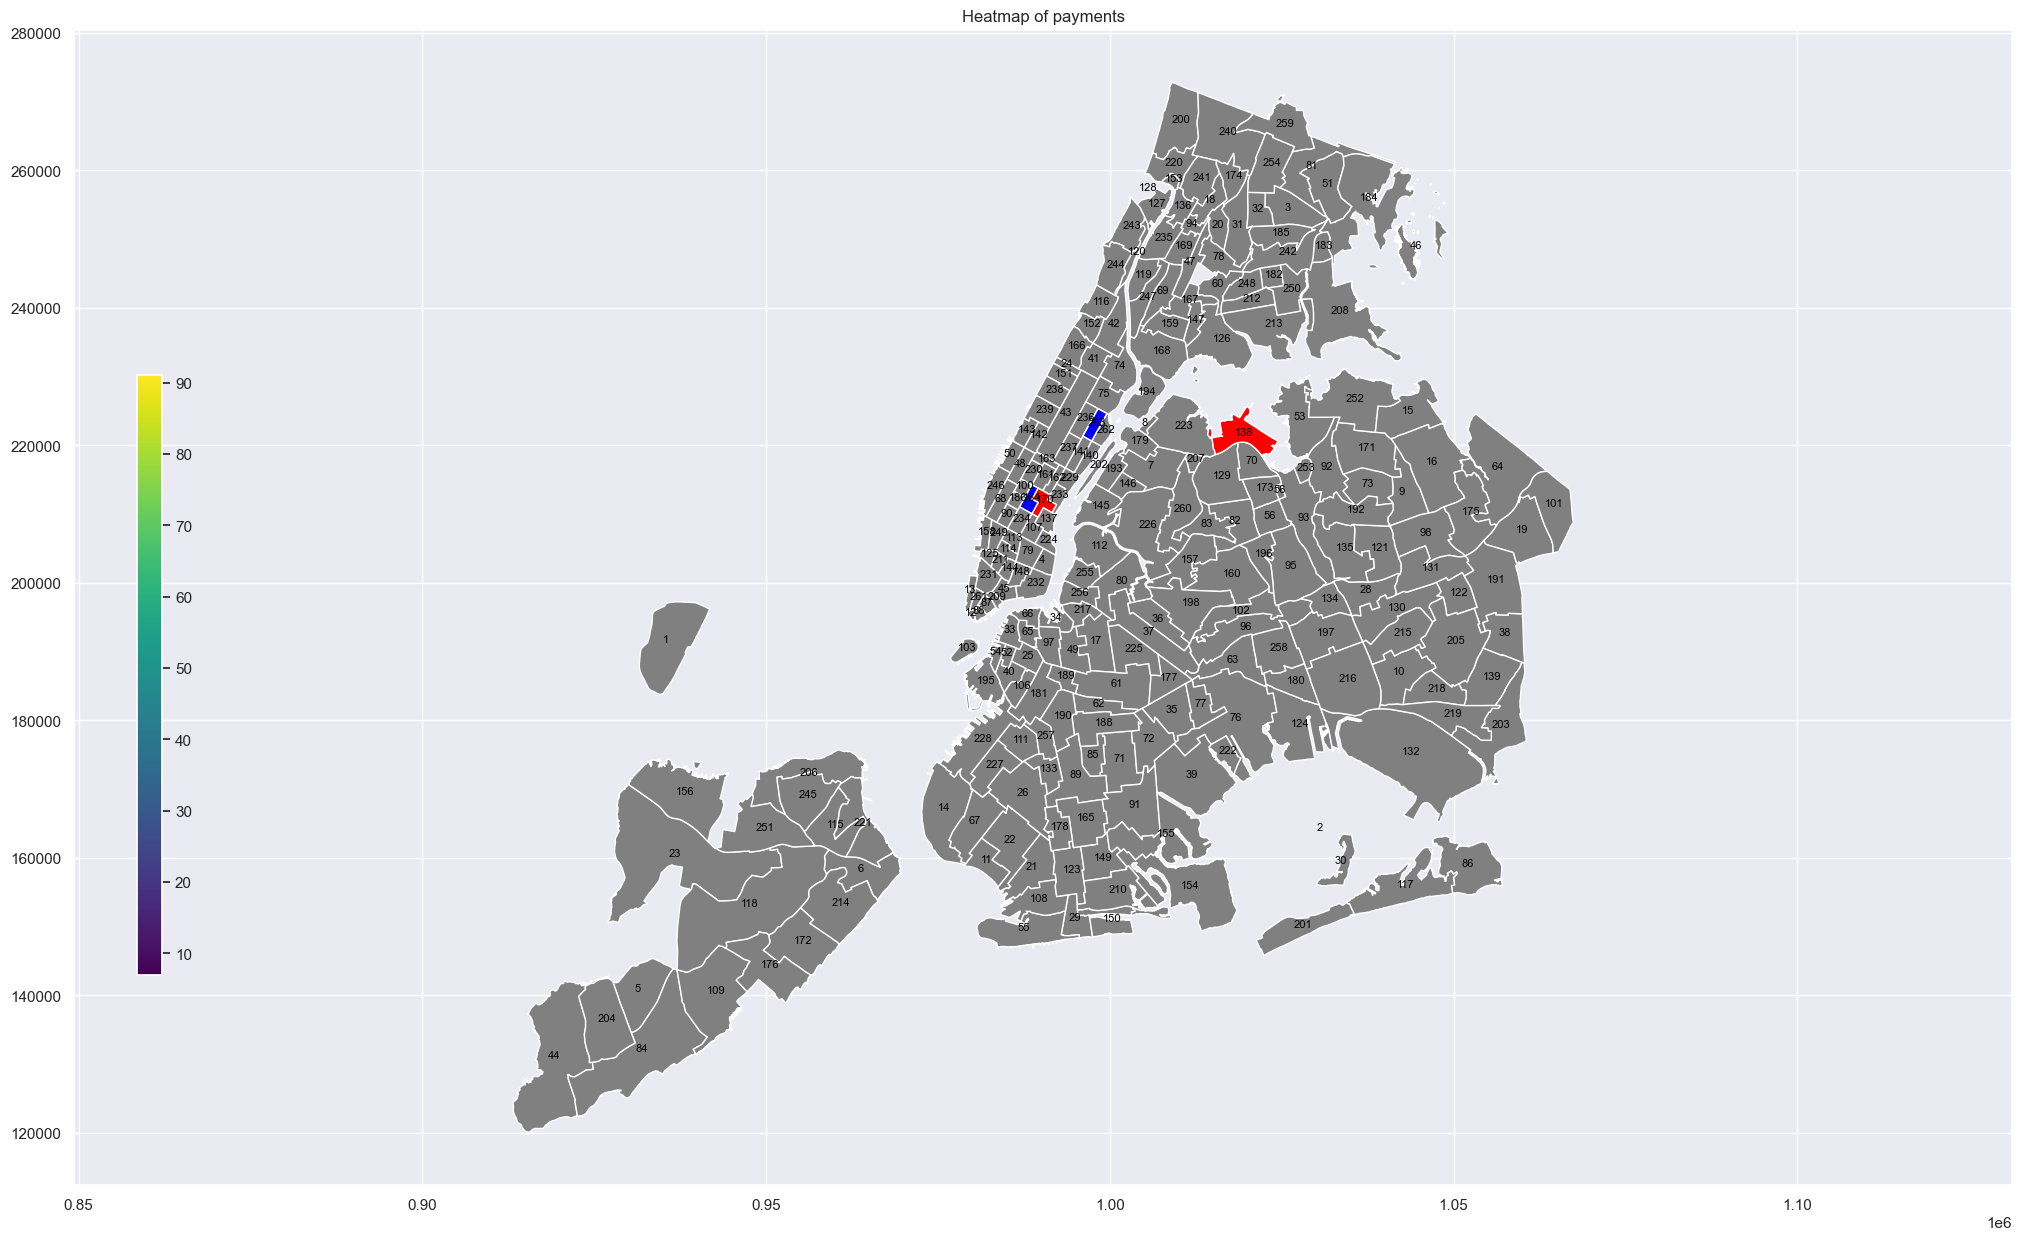

In [79]:
# Total Ammount por PULocationID
dfPULocTA_all = df[['PULocationID','fare_amount']].groupby('PULocationID').mean(numeric_only=True)
## Hago la union del geo_map con la agrupacion por total_amount
## La hago con OBJECTID porque parece que el LocationID está algo mal
geo_map2 = geo_map.set_index('OBJECTID').join(other=dfPULocTA_all, how='inner')

selectionPU = df.loc[df['fare_amount']> 5000, 'PULocationID']
selectioDO = df.loc[df['fare_amount']> 5000, 'DOLocationID']

cmap = 'viridis'
fig, ax = plt.subplots(1, figsize=(25, 15))
ax = geo_map2[~geo_map2['LocationID'].isin(selectionPU&selectioDO)].plot(ax=ax,color = 'gray', figsize=(15,10))
ax = geo_map2[geo_map2['LocationID'].isin(selectionPU)].plot(ax=ax,column='fare_amount', color='red', figsize=(15,10))
ax = geo_map2[geo_map2['LocationID'].isin(selectioDO)].plot(ax=ax,column='fare_amount', color='blue', figsize=(15,10))
ax.axis("equal")
#ax.axis([lonmin, lonmax, latmin, latmax])

total_min = dfPULocTA_all.min()
total_max = dfPULocTA_all.max()

for x, y, label in zip(geo_map2.centroid.x, geo_map2.centroid.y, geo_map2['LocationID']):
    ax.annotate(label, xy=(x, y), xytext=(-5, 0), textcoords="offset points", color = 'black', fontsize = 8)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=total_min, vmax=total_max), cmap = cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.set_title('Heatmap of payments') 

In [81]:
# Hay un outlier enorme, lo vemos primero
df.loc[df['fare_amount']> 5000]
# No están tan lejos como para estar tan alto el valor ni tampoco dura tanto el viaje
# Consideramos que son datos erróneos y los eliminamos
df = df.loc[df['fare_amount']< 5000]

<Axes: >

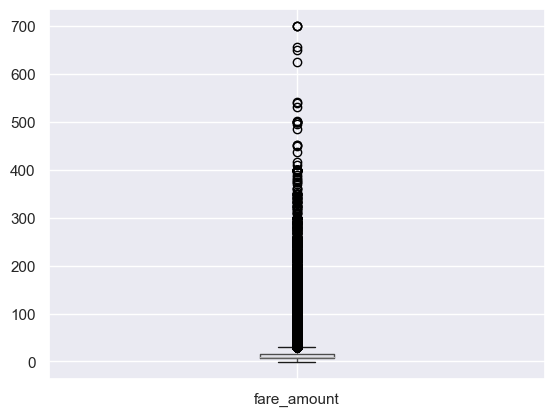

In [82]:
# observamos fare_amount
df[['fare_amount']].boxplot()

<Axes: >

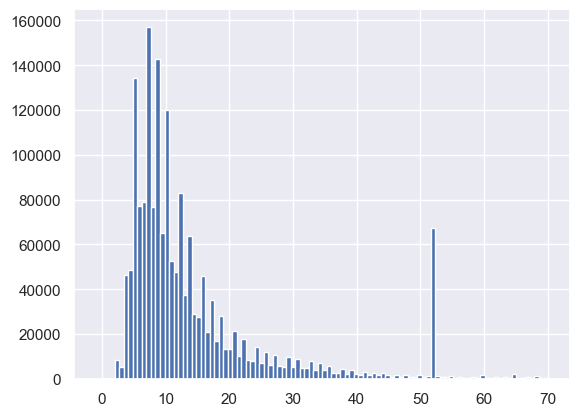

In [88]:
# Vemos un histograma sin outliers para mejor visualizacion
df.loc[df['fare_amount']< 70, 'fare_amount'].hist(bins=100)

In [92]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,airport_fee,date,time_of_day,month,duration_m,day_of_year,day_week,day_type
0,2022-11-20 14:50:04,2022-11-20 15:07:36,1.0,2.12,1.0,142,161,12.000000,0.00,False,2022-11-20,14,November,17.533333,11-20,6,weekend
1,2022-06-01 17:08:02,2022-06-01 18:36:57,1.0,17.40,2.0,132,48,52.000000,20.25,True,2022-06-01,17,June,88.916667,06-01,2,workday
2,2022-05-16 21:58:00,2022-05-16 22:06:44,1.0,1.97,1.0,142,236,9.000000,0.00,False,2022-05-16,21,May,8.733333,05-16,0,workday
3,2022-10-13 08:52:09,2022-10-13 09:12:49,1.0,2.28,1.0,239,140,14.000000,1.73,False,2022-10-13,8,October,20.666667,10-13,3,workday
4,2022-01-27 12:51:16,2022-01-27 12:51:30,1.0,0.00,5.0,209,209,63.500000,10.00,False,2022-01-27,12,January,0.233333,01-27,3,workday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800424,2022-06-11 22:59:39,2022-06-11 23:16:58,1.0,4.58,1.0,262,90,16.000000,3.96,False,2022-06-11,22,June,17.316667,06-11,5,weekend
1800425,2022-06-04 09:55:17,2022-06-04 10:16:31,1.0,6.00,99.0,218,101,33.200001,0.00,False,2022-06-04,9,June,21.233333,06-04,5,weekend
1800426,2022-08-25 13:39:09,2022-08-25 14:01:30,1.0,10.34,1.0,244,224,29.500000,8.20,False,2022-08-25,13,August,22.350000,08-25,3,workday
1800427,2022-05-13 09:23:13,2022-05-13 09:32:54,1.0,1.29,1.0,236,229,7.500000,2.70,False,2022-05-13,9,May,9.683333,05-13,4,workday


<Axes: xlabel='fare_amount', ylabel='tip_amount'>

d:\Users\juanp_schamun\Documents\GitRepositories\CEIA\AD\CEIA_Analisis_de_datos\.venv\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
d:\Users\juanp_schamun\Documents\GitRepositories\CEIA\AD\CEIA_Analisis_de_datos\.venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


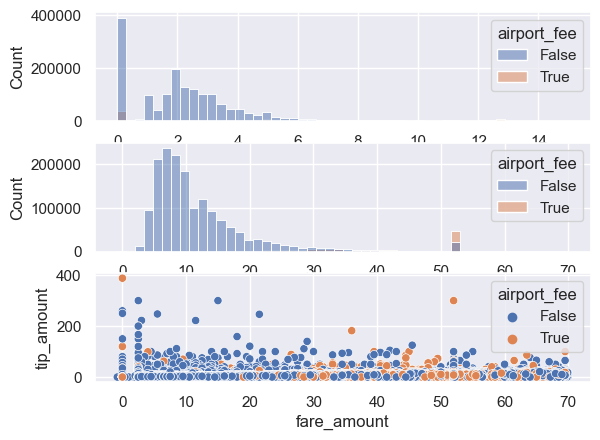

In [115]:
fig, ax = plt.subplots(3)
sns.histplot(ax=ax[0], data=df.loc[df['tip_amount']< 15], x="tip_amount", hue="airport_fee", bins=50)
sns.histplot(ax=ax[1], data=df.loc[df['fare_amount']< 70], x="fare_amount", hue="airport_fee", bins=50)
sns.scatterplot(ax=ax[2], data=df.loc[df['fare_amount']< 70], x="fare_amount", y='tip_amount', hue='airport_fee')

<Axes: xlabel='fare_amount', ylabel='Count'>

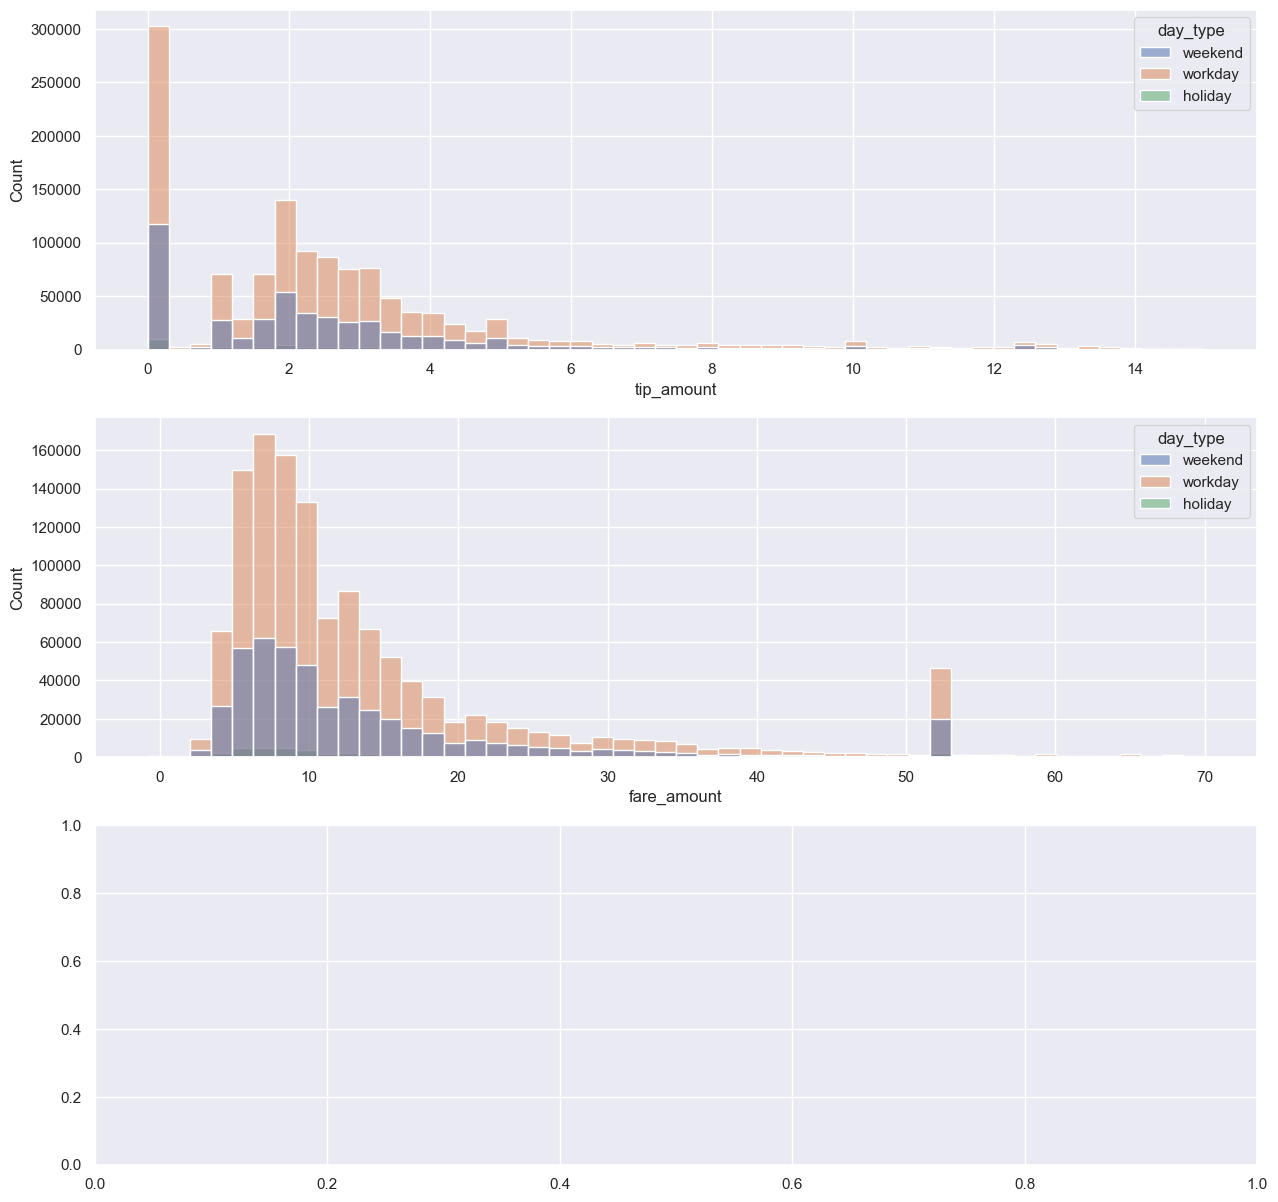

In [119]:
fig, ax = plt.subplots(3,figsize=(15, 15))
sns.histplot(ax=ax[0], data=df.loc[df['tip_amount']< 15], x="tip_amount", hue="day_type", bins=50)
sns.histplot(ax=ax[1], data=df.loc[df['fare_amount']< 70], x="fare_amount", hue="day_type", bins=50)